In [1]:
import io
import os
import base64

import numpy as np
import pandas as pd
from tqdm.cli import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, no_update, callback

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
from transformers import ViTImageProcessor, ViTModel
from sklearn.metrics.pairwise import pairwise_distances


sns.set_theme(style="darkgrid", palette="Set2")

/tmp/ipykernel_3727/3366275600.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Размерность cats: (15747, 12288)


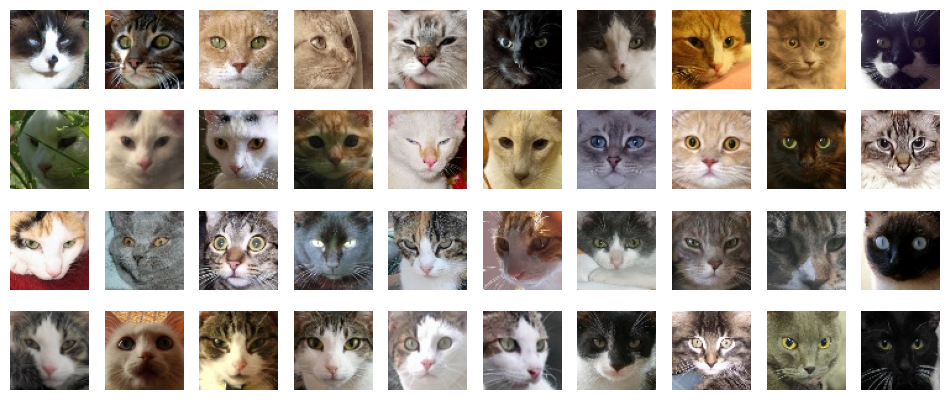

In [2]:
cats_path = "cats"
cats = []

for filename in os.listdir(cats_path):
    cats.append(plt.imread(os.path.join(cats_path, filename)))

cats = np.stack(cats).reshape(-1, 64 * 64 * 3)
print(f"Размерность cats: {cats.shape}")

plt.figure(figsize=(12, 5))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(cats[i].reshape(64, 64, 3))
    plt.axis("off")

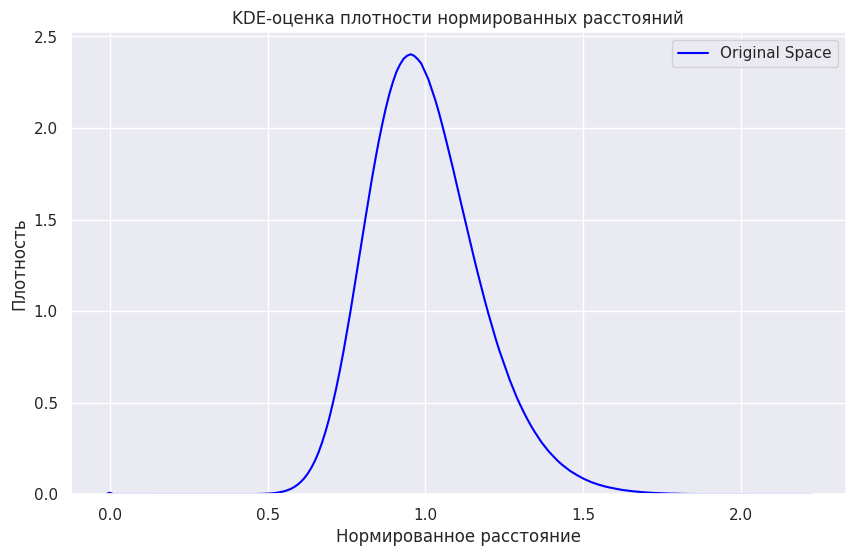

In [3]:

num_pairs = 10000
indices = np.random.choice(len(cats), size=(num_pairs, 2), replace=True)
pairs = cats[indices]

distances = pairwise_distances(pairs.reshape(num_pairs, -1))

mean_distance = np.mean(distances)
normalized_distances = distances / mean_distance

plt.figure(figsize=(10, 6))
sns.kdeplot(normalized_distances.flatten(), label="Original Space", color="blue")
plt.title("KDE-оценка плотности нормированных расстояний")
plt.xlabel("Нормированное расстояние")
plt.ylabel("Плотность")
plt.legend()
plt.show()


/tmp/ipykernel_31387/3383382757.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pca_distances, shade=True, label=f'{n_components} Components')
/tmp/ipykernel_31387/3383382757.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pca_distances, shade=True, label=f'{n_components} Components')
/tmp/ipykernel_31387/3383382757.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pca_distances, shade=True, label=f'{n_components} Components')


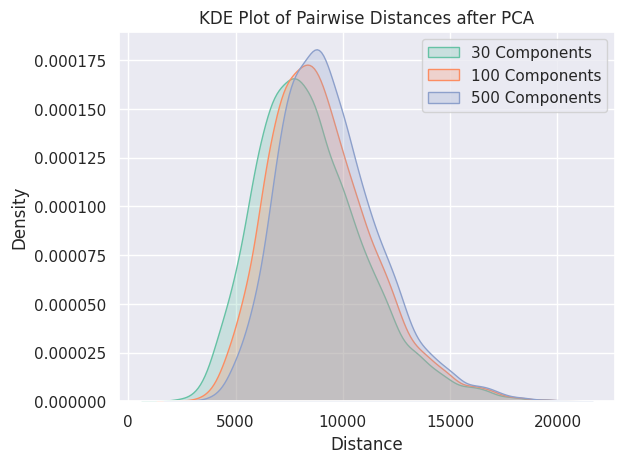

In [4]:
def pca_and_distances(n_components):
    pca = PCA(n_components=n_components)
    flattened_cats = cats.reshape(len(cats), -1)
    pca.fit(flattened_cats)

    transformed_cats = pca.transform(flattened_cats)

    pca_distances = []
    for pair in indices:
        img1 = transformed_cats[pair[0]]
        img2 = transformed_cats[pair[1]]
        distance = np.linalg.norm(img1 - img2)
        pca_distances.append(distance)

    return pca_distances

n_components_list = [30, 100, 500]

for n_components in n_components_list:
    pca_distances = pca_and_distances(n_components)
    sns.kdeplot(pca_distances, shade=True, label=f'{n_components} Components')

plt.xlabel('Distance')
plt.ylabel('Density')
plt.title('KDE Plot of Pairwise Distances after PCA')
plt.legend()
plt.show()


In [3]:
cats_vectors = [cat.flatten() for cat in cats]
cats_vectors = np.array(cats_vectors)

n_clusters = 5  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(cats_vectors)



KMeans(n_clusters=5, random_state=42)

In [ ]:
def visualize_images_clusterisation(images, projection, clusters, port=None):

    fig = px.scatter(
        x=projection[:, 0],
        y=projection[:, 1],
        hover_name=clusters,
        hover_data={"image_idx": list(range(len(images)))},
        color=clusters.astype(str),
        width=1000,
        height=800,
        title="PCA проекция изображений на плоскость",
        size=[1] * len(images),
        size_max=12,
    )

    fig.update_traces(
        hoverinfo="none",
        hovertemplate=None,
    )

    app = Dash(__name__)

    app.layout = html.Div(
        className="container",
        children=[
            dcc.Graph(id="graph-2-dcc", figure=fig, clear_on_unhover=True),
            dcc.Tooltip(id="graph-tooltip-2", direction="bottom"),
        ],
    )

    @callback(
        Output("graph-tooltip-2", "show"),
        Output("graph-tooltip-2", "bbox"),
        Output("graph-tooltip-2", "children"),
        Output("graph-tooltip-2", "direction"),
        Input("graph-2-dcc", "hoverData"),
    )
    def display_hover(hoverData):

        if hoverData is None:
            return False, no_update, no_update, no_update

        hover_data = hoverData["points"][0]
        image_idx = hover_data["customdata"][0]
        image = Image.fromarray(images[image_idx].reshape(64, 64, 3))

        buffer = io.BytesIO()
        image.save(buffer, format="jpeg")
        encoded_image = base64.b64encode(buffer.getvalue()).decode()
        image_url = "data:image/jpeg;base64, " + encoded_image

        image_children = [
            html.Img(
                src=image_url,
                style={"width": "196px"},
            ),
        ]

        return True, hover_data["bbox"], image_children, "top"

    if port is None:
        port = str(np.random.randint(5000, 15000))
    app.run(port=port, debug=True, jupyter_height=800)

    return app

In [6]:
pca = PCA(n_components=2)
cats_flattened = cats.reshape(len(cats), -1)
projection = pca.fit_transform(cats_flattened)

n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(cats_flattened)

visualize_images_clusterisation(cats, projection, clusters)


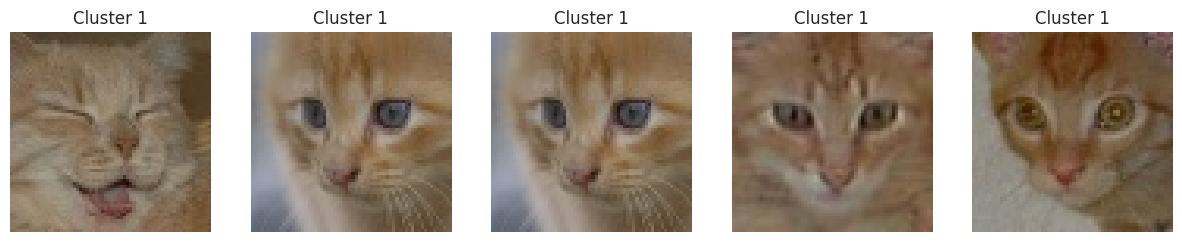

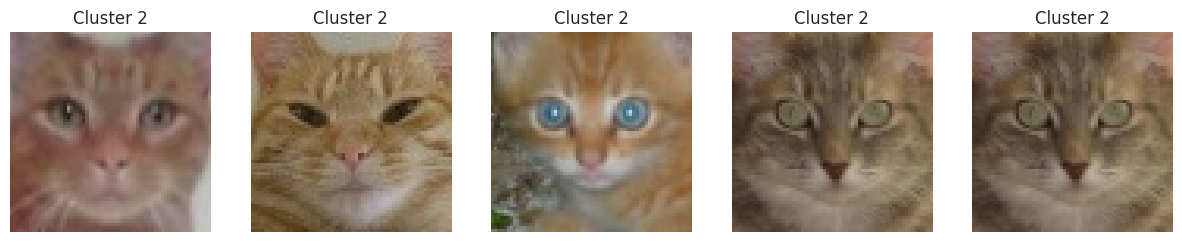

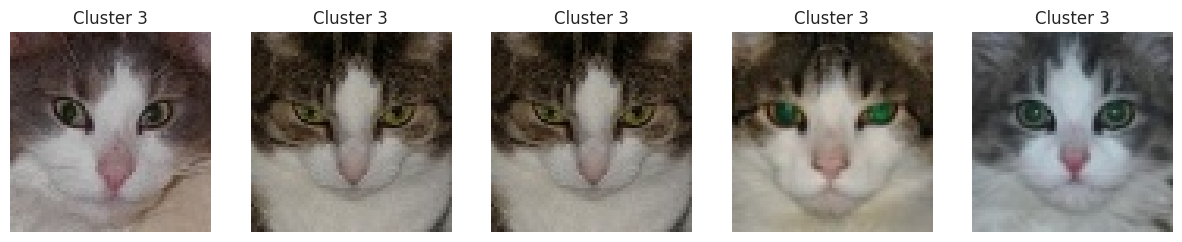

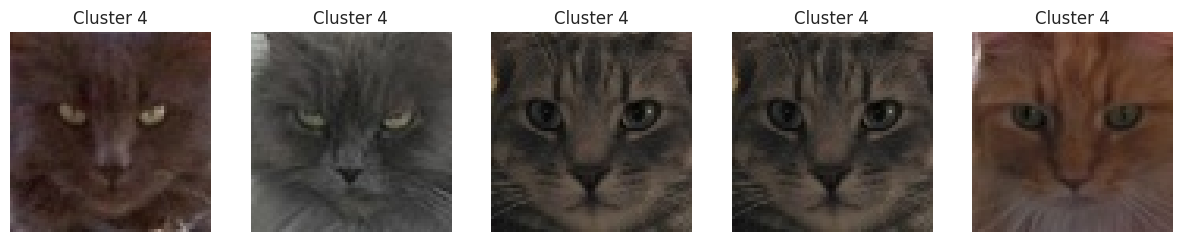

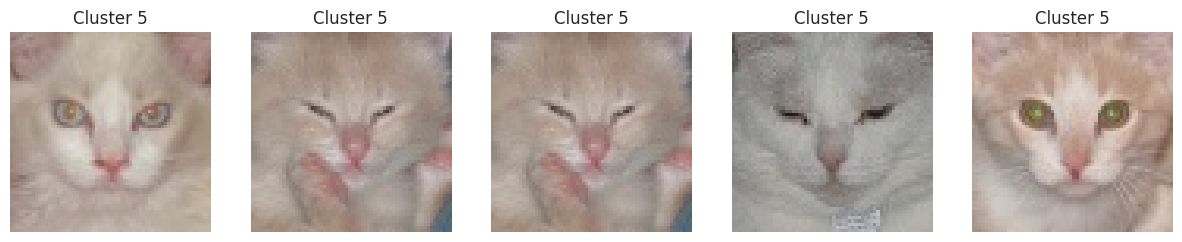

In [12]:
def plot_typical_images(images, cluster_centers, labels, num_images=5):
    n_clusters = len(cluster_centers)
    fig, axes = plt.subplots(n_clusters, num_images, figsize=(15, 10))

    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]

        distances = np.linalg.norm(images - cluster_centers[i], axis=1)

        closest_indices = cluster_indices[np.argsort(distances)[:num_images]]

        for j, image_idx in enumerate(closest_indices):
            ax = axes[i, j]
            image = images[image_idx].reshape(64, 64, 3)  
            ax.imshow(image.astype(np.uint8))  
            ax.set_title(f"Cluster {i+1}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

distances_to_centers = np.zeros((len(cats_flattened), n_clusters))
for i in range(n_clusters):
    distances_to_centers[:, i] = np.linalg.norm(cats_flattened - kmeans.cluster_centers_[i], axis=1)

num_images_per_cluster = 5
for i in range(n_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    closest_indices = cluster_indices[np.argsort(distances_to_centers[cluster_indices, i])[:num_images_per_cluster]]
    cluster_images = cats[closest_indices]
    
    plt.figure(figsize=(15, 3))
    for j, image in enumerate(cluster_images):
        plt.subplot(1, num_images_per_cluster, j + 1)
        image = image.reshape(64, 64, 3)  
        plt.imshow(image.astype(np.uint8)) 
        plt.title(f"Cluster {i+1}")
        plt.axis('off')
    plt.show()



Можно заметить, что котики в данных пяти кластерах имеют отличительные черты, к примеру для первого кластера характерны рыжие котики с маленькой мордочкой и голубыми глазами. Второй кластер похож на первый, но сюда попадают котики с коричневой шерсткой и зелеными глазами. Для третьего кластера характерны котики у которых коричнево-серая шерстка на макушке, а внизу белая. В четвертый кластер попадают черные котики и в пятом белые.


Когда мы работаем с изображениями в пространстве высокой размерности (например, векторы размером 64x64x3), обычно возникают проблемы с проклятием размерности. Это может привести к тому, что расстояния между изображениями становятся менее информативными, и алгоритм кластеризации может начать "слишком хорошо" адаптироваться к данным. Это означает, что "типичные" изображения могут быть не совсем представительными для всего кластера, а лишь отражать особенности маленькой области в пространстве высокой размерности.

In [23]:
n_components = 100
pca = PCA(n_components=n_components)
cats_pca = pca.fit_transform(cats)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(cats_pca)


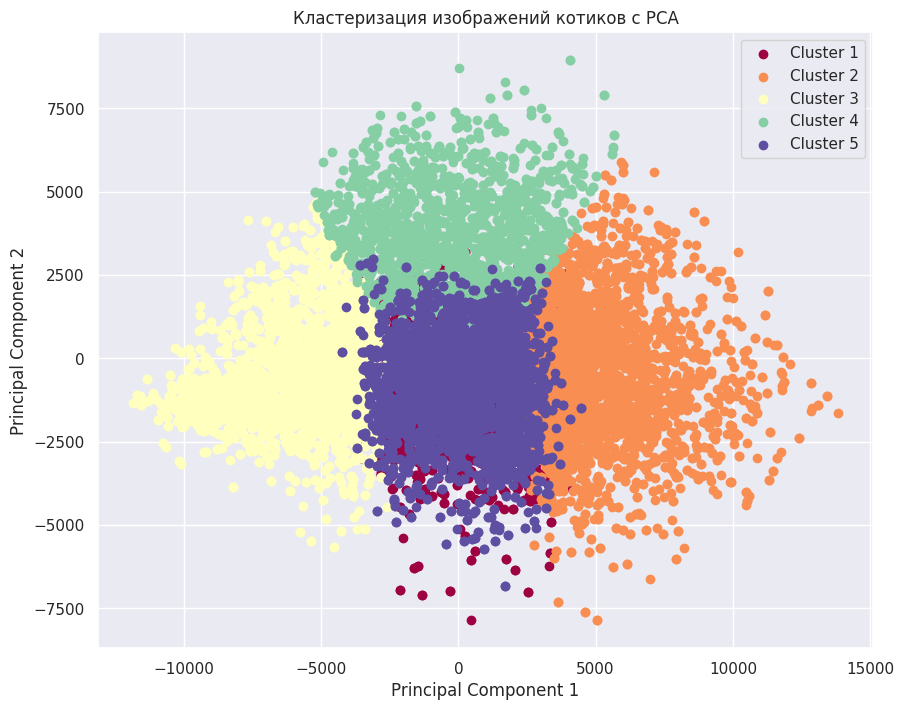

In [27]:
def plot_clusters_2d(data, labels, title):
    unique_labels = np.unique(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(unique_labels):
        cluster_data = data[labels == label]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=[colors[i]], label=f'Cluster {label + 1}')
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

plot_clusters_2d(cats_pca, labels, title="Кластеризация изображений котиков с PCA")


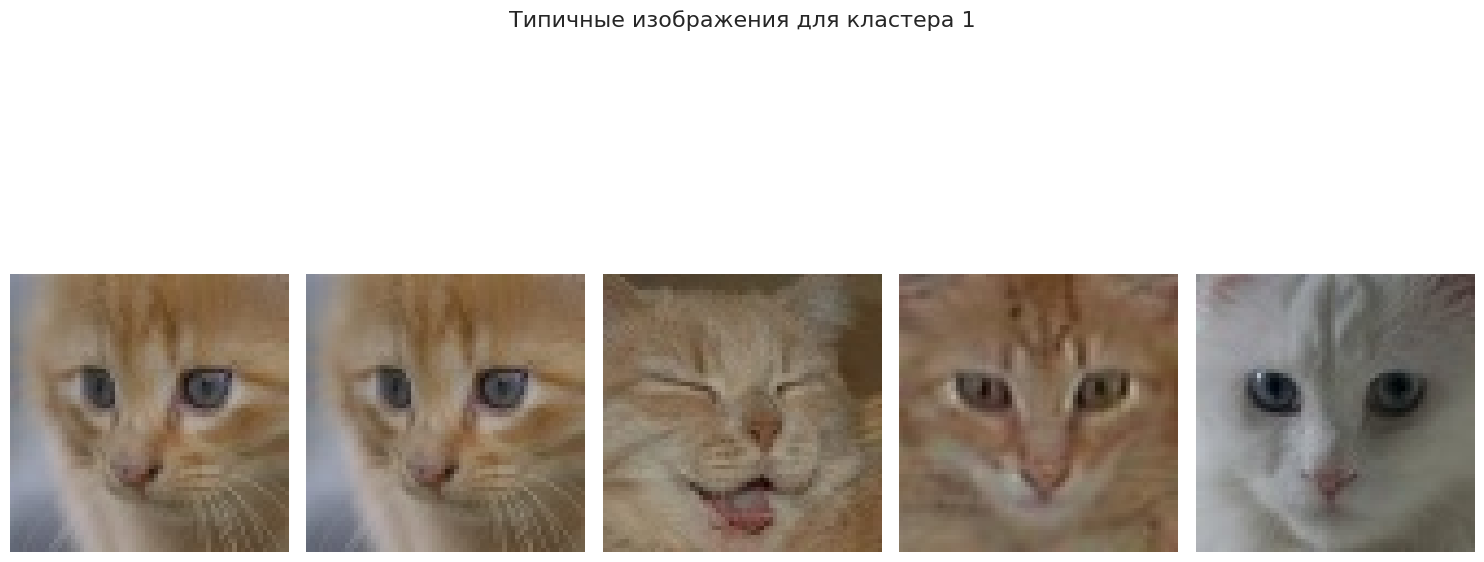

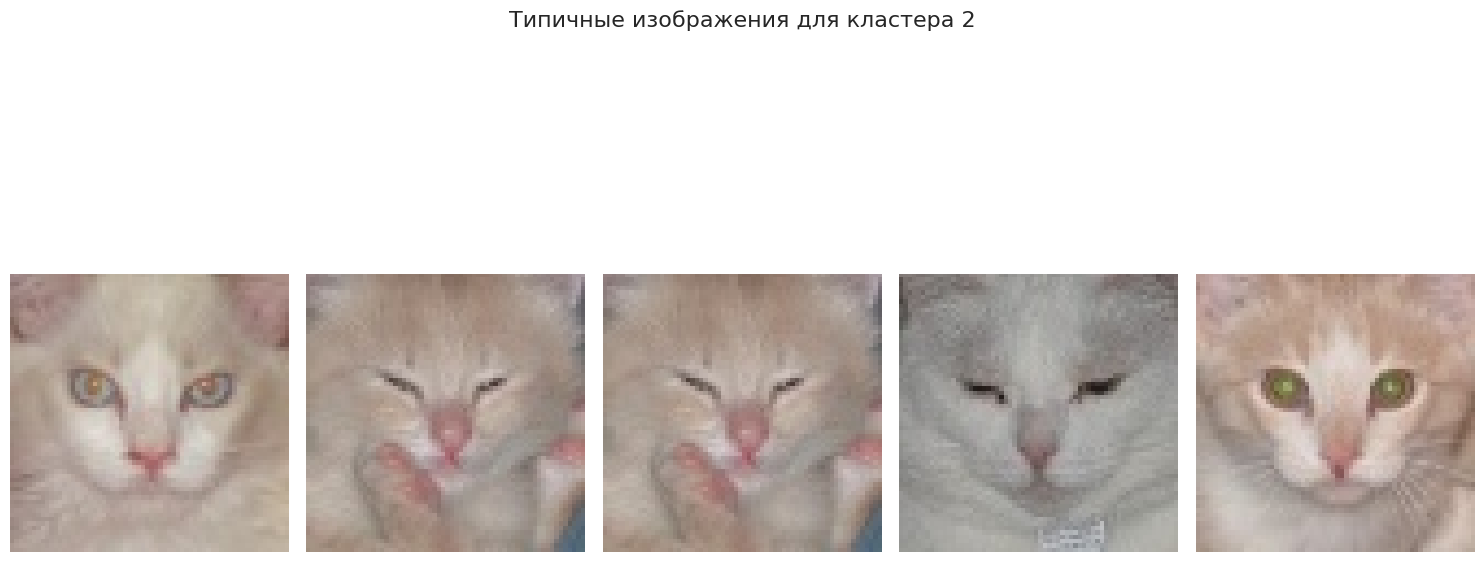

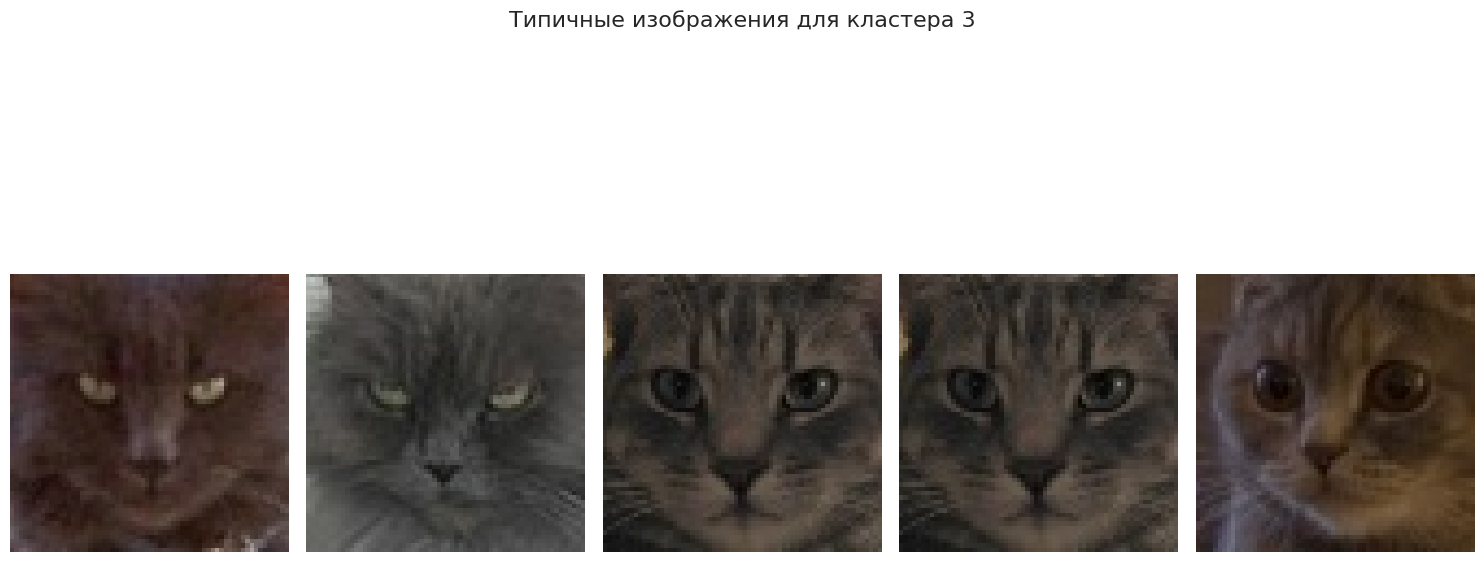

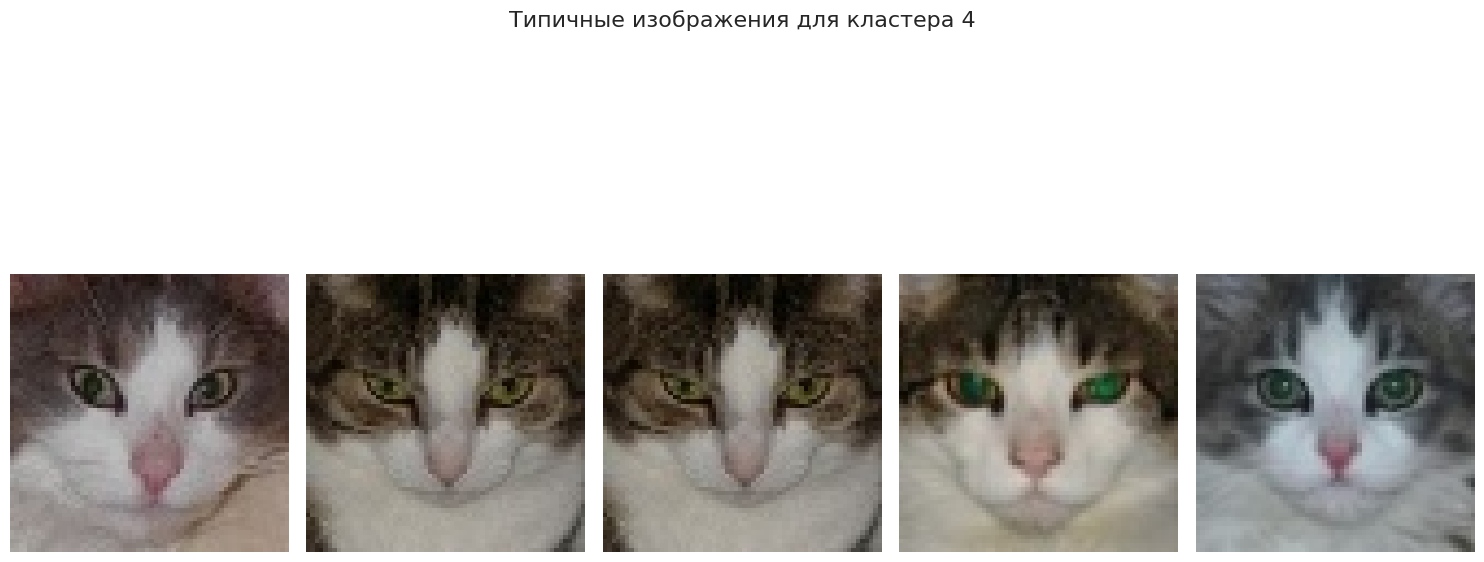

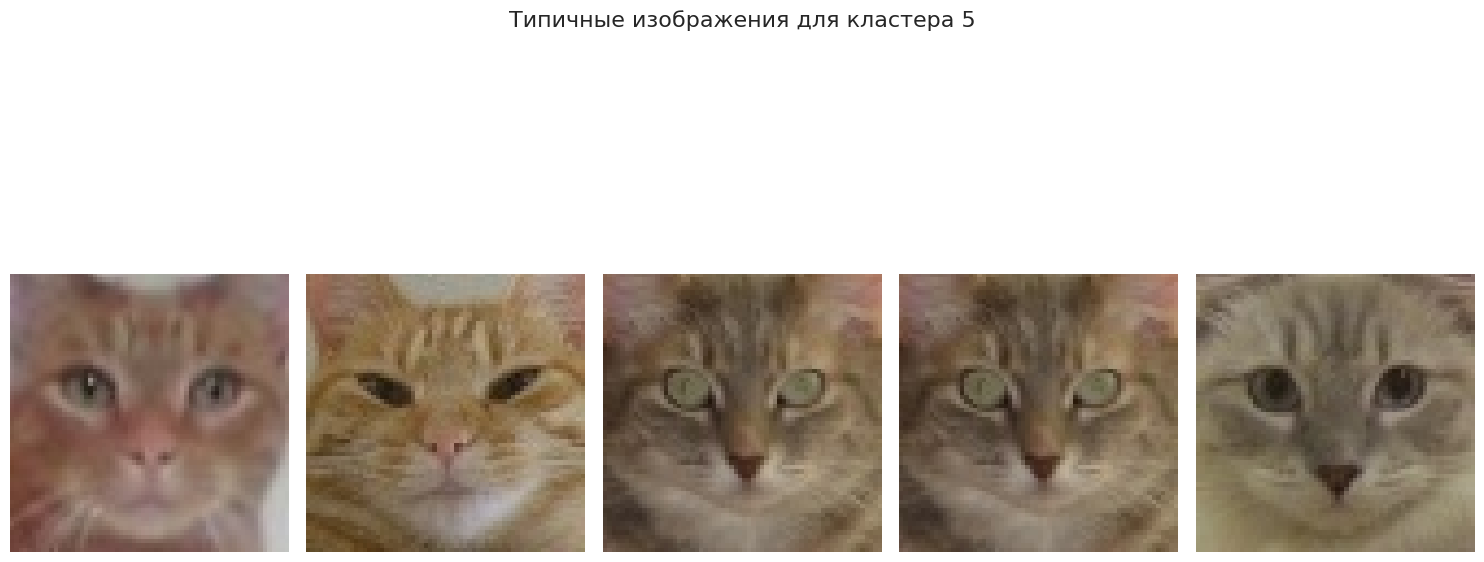

In [28]:
def plot_typical_images(images, labels, n_clusters, n_typical=5):
    for cluster_num in range(n_clusters):
        cluster_indices = np.where(labels == cluster_num)[0]
        cluster_images = images[cluster_indices]
        distances = np.linalg.norm(cluster_images - cluster_images.mean(axis=0), axis=1)
        typical_indices = np.argsort(distances)[:n_typical]
        typical_images = cluster_images[typical_indices]
        plot_images(typical_images, title=f"Типичные изображения для кластера {cluster_num + 1}")

plot_typical_images(cats, labels, n_clusters)



Можно заметить, что котики в данных пяти кластерах имеют отличительные черты, к примеру для первого кластера характерны рыжие котики с маленькой мордочкой и голубыми глазами. во втором кластере у нас белые котики,. Для третьего кластера характерны черные котики . В четвертый кластер попадают котики у которых коричнево-серая шерстка на макушке, а внизу белая. В пятом кластере серо-коричневые котики.
